# Классификация рукописных букв EMNIST 


Исходные данные для обучения и валидации моделей взяты на сайте NIST:
[EMNIST Dataset](https://www.nist.gov/itl/products-and-services/emnist-dataset)

Данные для итоговых предсказаний взяты непосредственно из соревнования kaggle: [Data test](https://www.kaggle.com/c/jds3/data?select=emnist-letters-test-sh.csv) 

# Загрузка и просмотр данных

In [ ]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mlxtend.data import loadlocal_mnist
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler,Normalizer,MinMaxScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
import gc
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans

In [ ]:
#объявим метод записи предсказаний в файл, который будет использоваться для всех моделей
def write(model,name,final_test):
  y_final=model.predict(final_test)
  d=pd.DataFrame(list(range(1,y_final.shape[0]+1)))
  d['Category']=y_final
  d.columns=['Id','Category']
  d.set_index('Id',drop=True,inplace=True)
  d.to_csv('prediction_{:}.csv'.format(name))

In [ ]:
#объявим функцию оценки модели
def acc(model,X_train,y_train,X_test,y_test):
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  return [model,metrics.accuracy_score(y_test,y_pred)]

In [ ]:
#объявим функцию оценки модели без тренировки
def acc_pred(model,X_test,y_test):
  y_pred=model.predict(X_test)
  return [model,metrics.accuracy_score(y_test,y_pred)]

In [ ]:
#загрузка данных
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_images_filepath = '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/emnist-letters-train-images-idx3-ubyte'
training_labels_filepath = '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/emnist-letters-train-labels-idx1-ubyte'
test_images_filepath = '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/emnist-letters-test-images-idx3-ubyte'
test_labels_filepath = '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/emnist-letters-test-labels-idx1-ubyte'
final_test_filepath='/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/emnist-letters-test-sh.csv'

In [ ]:
X_train, y_train = loadlocal_mnist(training_images_filepath, training_labels_filepath)
X_test, y_test = loadlocal_mnist(test_images_filepath, test_labels_filepath)
final_test= np.array(pd.read_csv(final_test_filepath,header=None))

In [ ]:
#оценка количества объектов
print('Dimension of training images:', np.shape(X_train))
print('Dimension of trainig labels:',np.shape(y_train))
print('Dimension of testing images:', np.shape(X_test))
print('Dimension of testing labels:',np.shape(y_test))
print('Dimension of final testing images:',np.shape(final_test))

Dimension of training images: (124800, 784)
Dimension of trainig labels: (124800,)
Dimension of testing images: (20800, 784)
Dimension of testing labels: (20800,)
Dimension of final testing images: (14800, 784)


In [ ]:
#формируем небольшие выборки для менее длительных вычислений
X_train_small=X_train[::26]
y_train_small=y_train[::26]
X_test_small=X_test[::15]
y_test_small=y_test[::15]

In [ ]:
#посмотрим на значения объектов 
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,  20, 114, 125,  82,  37,
        37,  39, 115, 157,  94,  21,  10,  32,  37,  37,  37,  37,  37,
        37,  37,  82, 125, 114,  20,   0,   0,   0,   3, 109, 245, 249,
       233, 217, 217, 217, 245, 251, 234, 172, 142, 203, 217, 217, 217,
       217, 217, 217, 217, 233, 249, 245, 109,   3,   0,   0,   4, 114,
       253, 254, 254, 254, 254, 254, 254, 254, 254, 252, 251, 254, 254,
       254, 254, 254, 254, 254, 254, 254, 254, 254, 127,   4,   0,   0,
         0,  45, 214, 233, 251, 254, 254, 254, 254, 255, 255, 25

In [ ]:
#посмотрим на метки классов
np.unique(y_train, return_counts=True)
#видим, что классы распределены равномерно

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=uint8),
 array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800]))

In [ ]:
#сопоставим букву номеру
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q','r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 
#       [ 1,  2,    3,    4,   5,   6,  7,    8,  9,    10, 11, 12,   13, 14, 15,   16,   17, 18, 19,   20, 21,   22,   23, 24, 25,   26]

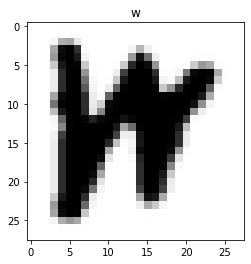

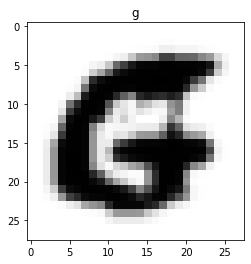

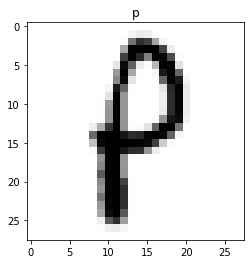

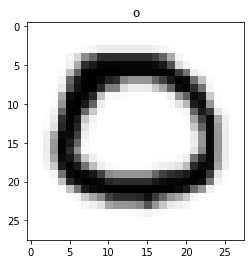

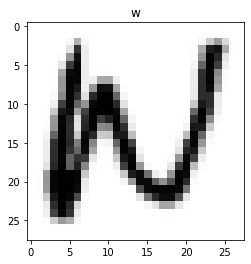

<Figure size 432x288 with 0 Axes>

In [ ]:
#посмотрим на примеры объектов
imgsize=(28,28)
for i in range(5):
  plt.imshow(X_train[i].reshape(imgsize).T,cmap='Greys')
  plt.title(letters[y_train[i]-1])
  plt.figure()

# KNN

In [ ]:
#попробуем классифицировать объекты методом KNN с k=10 на части выборки
neigh = KNeighborsClassifier(n_neighbors=10)
res = acc_small(neigh,X_train_small, y_train_small,X_test_small,y_test_small)
#оценим точность предсказаний на тестовой выборке 
res[1]

0.6759615384615385

In [ ]:
#воспользуемся методом снижения размерности PCA
pca = PCA(n_components=35)
X_train_trans= pca.fit_transform(X_train_small)

neigh = KNeighborsClassifier(n_neighbors=10)
res=acc(neigh,X_train_trans, y_train_small,pca.transform(X_test_small),y_test_small)

res[1]

0.7221153846153846

In [ ]:
#точность выросла, ищем наиболее подходящие параметры модели
knn = Pipeline([
        ('PCA', PCA()), 
        ('KNN', KNeighborsClassifier())
    ])

parameters = {'PCA__n_components':[2,5,10,30,50,100,200], 'KNN__n_neighbors':[3,5,10,20]}
grid = GridSearchCV(knn, param_grid=parameters, cv=5,scoring='accuracy')
grid.fit(X_train_small,y_train_small)
grid.best_params_

{'KNN__n_neighbors': 3, 'PCA__n_components': 30}

In [ ]:
#оценим точность модели с подходящими параметрами на всей выборке 
pca=PCA(n_components=grid.best_params_['PCA__n_components'])
res=acc(grid.best_estimator_,pca.fit_transform(X_train), y_train,pca.transform(X_test),y_test)
res[1]

0.8833653846153846

In [ ]:
#попробуем найти еще более подходящие параметры модели
knn = Pipeline([
        ('PCA', PCA()), 
        ('KNN', KNeighborsClassifier())
    ])

parameters = {'PCA__n_components': list(range(25,36)), 'KNN__n_neighbors':[3,4,5]}
grid = GridSearchCV(knn, param_grid=parameters, cv=5,scoring='accuracy')
grid.fit(X_train_small,y_train_small)
grid.best_params_

{'KNN__n_neighbors': 5, 'PCA__n_components': 27}

In [ ]:
#с этими параметрами точность еще немного выросла 
pca=PCA(n_components=grid.best_params_['PCA__n_components'])
res=acc(grid.best_estimator_,pca.fit_transform(X_train), y_train,pca.transform(X_test),y_test)
res[1]

0.8857211538461538

In [ ]:
#сформируем предсказания для финальной выборки и запишем их в файл
write(res[0],'KNN')

In [ ]:
#попробуем рандомизированный PCA
pca = PCA(n_components=27,svd_solver='randomized')
neigh = KNeighborsClassifier(n_neighbors=5)
res=acc(neigh,pca.fit_transform(X_train_small), y_train_small, pca.transform(X_test_small), y_test_small)
res[1]

0.7577505407354002

In [ ]:
#попробуем ядерные методы снижения размерности
pca = KernelPCA(n_components=27)
neigh = KNeighborsClassifier(n_neighbors=5)
res=acc(neigh,pca.fit_transform(X_train_small), y_train_small, pca.transform(X_test_small), y_test_small)
res[1]

0.7591925018024513

In [ ]:
#обучение аналогичной модели на всех тренировочных данных заканчивается исчерпанным лимитом ОЗУ 
#поэтому попробуем только сформировать предсказания для всех тестовых данных, что не особенно увеличивает точность
acc_pred(res[0],pca.transform(X_test), y_test)[1]

0.7626923076923077

In [ ]:
# с большим количеством компонент точность ниже
pca = KernelPCA(n_components=100)
neigh = KNeighborsClassifier(n_neighbors=5)
res=acc(neigh,pca.fit_transform(X_train_small), y_train_small, pca.transform(X_test_small), y_test_small)
res[1]

0.7476568132660418

In [ ]:
#с полиномиальным ядром точность ниже
pca = KernelPCA(n_components=27,kernel='poly')
neigh = KNeighborsClassifier(n_neighbors=5)
res=acc(neigh,pca.fit_transform(X_train_small), y_train_small, pca.transform(X_test_small), y_test_small)
res[1]

0.7015140591204038

Метод KNN показал неплохой результат даже без применения дополнительных инструментов, но при этом предсказание на всей тестовой выборке длилось достаточно долго - около 40 минут. Алгоритм KNN в сочетании с PCA показал существенный прирост точности и снижение времени выполнения алгоритма.

# Logistic Regression

In [ ]:
#перейдем к логистической регрессии 
#время выполнения 13 мин
LR = LogisticRegression(max_iter=10000)
res=acc(LR, X_train_small, y_train_small,X_test_small,y_test_small)
res[1]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5240384615384616

In [ ]:
#модель не cошлась, поэтому попробуем стандартизировать данные, как указано в предупреждении и увидим улучшение результата
scaler=StandardScaler()
LR = LogisticRegression(max_iter=10000)
res=acc(LR, scaler.fit_transform(X_train_small), y_train_small,scaler.transform(X_test_small),y_test_small)
res[1]

0.5778846153846153

In [ ]:
#найдем оптимальные параметры модели с использованием снижения размерности PCA 
#время выполнения 2.5 часа
LR = Pipeline([
        ('PCA', PCA()), 
        ('LR', LogisticRegression(solver='saga',max_iter=10000, penalty='elasticnet'))
    ])

parameters = {'PCA__n_components':[2,5,10,30,50,100,200], 
              'LR__l1_ratio':[0,1,0.5]                         
              } 
grid = GridSearchCV(LR, param_grid=parameters, cv=5,scoring='accuracy')
grid.fit(X_train_small,y_train_small)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('PCA',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('LR',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                          

In [ ]:
grid.best_params_

{'LR__l1_ratio': 0, 'PCA__n_components': 50}

In [ ]:
#c более оптимальными параметрами модель стала точнее
#время выполнения 38 сек
res=acc(grid.best_estimator_,X_train, y_train,X_test,y_test)
res[1]

0.6902884615384616

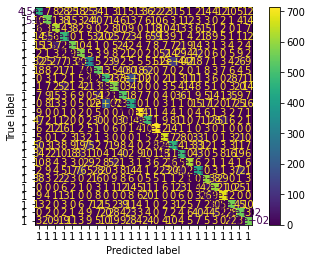

In [ ]:
#визуализируем матрицу ошибок классификации
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test,grid.best_estimator_.predict(X_test)),display_labels=y_test)
disp.plot()
plt.show()

Логистическая регрессия показала средний результат, и после подбора оптимальных параметров с использованием метода снижения размерности PCA достигла лишь 69% точности. 

# Naive bayes


In [ ]:
#воспользуемся классификатором Naive bayes
#время выполнения 33 сек
MNB = MultinomialNB()
res=acc(MNB,X_train, y_train,X_test,y_test)
res[1]

0.5782692307692308

In [ ]:
#посмотрим на остальные метрики
print(metrics.classification_report(y_test,MNB.predict(X_test),target_names=letters))
#хуже всего распознается буква l, что совершенно не удивительно

              precision    recall  f1-score   support

           a       0.39      0.42      0.41       800
           b       0.56      0.64      0.60       800
           c       0.69      0.63      0.66       800
           d       0.47      0.50      0.48       800
           e       0.70      0.56      0.62       800
           f       0.63      0.54      0.58       800
           g       0.54      0.36      0.43       800
           h       0.57      0.55      0.56       800
           i       0.39      0.79      0.52       800
           j       0.57      0.55      0.56       800
           k       0.66      0.58      0.61       800
           l       0.16      0.07      0.09       800
           m       0.69      0.86      0.77       800
           n       0.49      0.53      0.51       800
           o       0.66      0.80      0.72       800
           p       0.62      0.77      0.69       800
           q       0.58      0.49      0.53       800
           r       0.56    

In [ ]:
#снизим размерность данных и применим классификатор. получим ошибку, т.к. на вход можно подавать только положительные значения
pca=PCA(n_components=50)
res=acc(MNB,pca.fit_transform(X_train), y_train,pca.transform(X_test),y_test)
res[1]

ValueError: ignored

In [ ]:
#посмотрим, что будет с нормализованной и сокращенной выборкой. результат незначительно улучшился.
pca=PCA(n_components=50)
Scaler=MinMaxScaler()
res=acc(MNB,Scaler.fit_transform(pca.fit_transform(X_train)), y_train,Scaler.transform(pca.transform(X_test)),y_test)
res[1]

0.5806730769230769

In [ ]:
#посмотрим, что будет только с нормализованной выборкой. результат чуть хуже, но разница не очень существенная
pca=PCA(n_components=50)
Scaler=MinMaxScaler()
res=acc(MNB,Scaler.fit_transform(X_train), y_train,Scaler.transform(X_test),y_test)
res[1]

0.5782692307692308

In [ ]:
#в качестве эксперимента используем гауссовский классификатор для заведомо ненормально распределенных данных. естественно, получим плохой результат
GNB=GaussianNB()
res=acc(GNB,X_train, y_train,X_test,y_test)
res[1]

0.3496153846153846

In [ ]:
#CNB больше подходит для разбалансированных выборок и дает результат хуже, чем MultinomialNB
CNB = ComplementNB()
res=acc(CNB,X_train, y_train,X_test,y_test)
res[1]

0.4790865384615385

Наивный байесовский классификатор показывает результаты хуже, чем логистическая регрессия, и метод главных компонент несущественно влияет на результаты.

# Linear SVC (или SVM с ядром)


In [ ]:
#протестируем метод опорных векторов 
steps = [('scaler', StandardScaler()), ('SVM', SVC())]
pipeline = Pipeline(steps) # define Pipeline object
res=acc(pipeline,X_train_small,y_train_small,X_test_small,y_test_small)
res[1]

0.7426099495313626

In [ ]:
#оценим модель на всей выборке 
steps = [('scaler', StandardScaler()), ('SVM', SVC())]
pipeline = Pipeline(steps) # define Pipeline object
res=acc(pipeline,X_train,y_train,X_test,y_test)
res[1]

0.8880769230769231

In [ ]:
#поищем более подходящие параметры по сетке
#время выполнения 100 мин
steps = [('scaler', StandardScaler()), ('SVM', SVC())]
pipeline = Pipeline(steps) # define Pipeline object
parameters = {'SVM__C':[0.001, 0.1, 100, 10e5], 'SVM__gamma':[10,1,0.1,0.01,0.001], 'SVM__kernel':['poly','rbf','linear']}
grid = GridSearchCV(pipeline, param_grid=parameters,scoring='accuracy')
grid.fit(X_train_small, y_train_small)
print(grid.score(X_test_small, y_test_small))
print(grid.best_params_)


0.7692307692307693
{'SVM__C': 0.1, 'SVM__gamma': 0.01, 'SVM__kernel': 'poly'}


In [ ]:
#оценим работу модели c выбранными параметрами на всей выборке
#время выполнения 84 мин
res= acc(SVC(C=0.1, gamma=0.01, kernel= 'poly'),X_train,y_train,X_test,y_test)
res[1]

0.9026923076923077

In [ ]:
#запишем результат в файл
write(res[0],'SVM')

In [ ]:
#скейлинг улучшает предсказание, но делает это очень долго (1.5 часа)
Scaler=StandardScaler()
res= acc(SVC(C=0.1, gamma=0.01, kernel= 'poly'),Scaler.fit_transform(X_train),y_train,Scaler.transform(X_test),y_test)
res[1]

0.9091346153846154

In [ ]:
#попробуем применить метод главных компонент к той же модели и чуть улучшим результат
#время выполнения почти 3 ч
pca=PCA(n_components=50)
res2=acc(res[0],pca.fit_transform(X_train), y_train,pca.transform(X_test),y_test)
res2[1]

0.9065384615384615

In [ ]:
#поищем оптимальное количество главных компонент 
for n in range(50,70):
    pca=PCA(n_components=n)
    Scaler=StandardScaler()
    res= acc(SVC(C=0.1, gamma=0.01, kernel= 'poly'),pca.fit_transform(Scaler.fit_transform(X_train_small)),y_train_small,
             pca.transform(Scaler.transform(X_test_small)),y_test_small)
    print(n,res[1])

50 0.7846153846153846
51 0.7884615384615384
52 0.7836538461538461
53 0.7817307692307692
54 0.7846153846153846
55 0.7903846153846154
56 0.7913461538461538
57 0.7894230769230769
58 0.7875
59 0.7894230769230769
60 0.7894230769230769
61 0.7884615384615384
62 0.7894230769230769
63 0.7903846153846154
64 0.7903846153846154
65 0.7894230769230769
66 0.7913461538461538
67 0.7884615384615384
68 0.7913461538461538
69 0.7875


In [ ]:
#cформируем модель с наиболее оптимальными параметрами
pca=PCA(n_components=56)
Scaler=StandardScaler()
res=acc(SVC(C=0.1, gamma=0.01, kernel= 'poly'),pca.fit_transform(Scaler.fit_transform(X_train)), y_train,pca.transform(Scaler.transform(X_test)),y_test)
res[1]

0.9091826923076923

In [ ]:
#запишем в файл результат, который в итоге дал лучший показатель на kaggle
write(res[0],'SVC',pca.transform(Scaler.transform(final_test)))

In [ ]:
#запустим поиск по сетке с учетом количества главных компонент
#время выполнения 5ч
steps = [('scaler', StandardScaler()), ('PCA',PCA()), ('SVM', SVC())]
pipeline = Pipeline(steps) # define Pipeline object
parameters = {'SVM__C':[0.001, 0.1,1,10, 100, 1000], 'SVM__gamma':[10,1,0.1,0.01,0.001], 'SVM__kernel':['poly','rbf','linear'],'PCA__n_components':[56,66,68]}
grid = GridSearchCV(pipeline, param_grid=parameters,scoring='accuracy')
grid.fit(X_train_small, y_train_small)
print(grid.score(X_test_small, y_test_small))
print(grid.best_params_)


0.7923076923076923
{'PCA__n_components': 56, 'SVM__C': 100, 'SVM__gamma': 0.001, 'SVM__kernel': 'poly'}


In [ ]:
#оценим точность модели с подходящими параметрами на всей выборке и получим самый точный результат
#10 мин
res=acc(grid.best_estimator_,X_train, y_train,X_test,y_test)
res[1]

0.9096153846153846

In [ ]:
#запишем результат в файл и после загрузки на kaggle выясним, что точность на финальной тестовой выборке не увеличилась, 
#из чего делаем вывод, что модель уже начала переобучаться
write(grid.best_estimator_,'SVC_3',final_test)

In [ ]:
#вместо LinearSVC попробуем применить SGDClassifier, который позволяет избежать копирования массива данных
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
res=acc(clf,X_train_small,y_train_small,X_test_small,y_test_small)
res[1]

0.6192307692307693

In [ ]:
#без скейлинга точность значительно ниже
clf = SGDClassifier()
res=acc(clf,X_train_small,y_train_small,X_test_small,y_test_small)
res[1]

0.5086538461538461

In [ ]:
#с методом главных компонент точность чуть выше
pca=PCA(n_components=50)
res=acc(SGDClassifier(),StandardScaler().fit_transform(pca.fit_transform(X_train_small)), y_train_small,StandardScaler().fit_transform(pca.transform(X_test_small)),y_test_small)
res[1]

0.5740384615384615

In [ ]:
#увеличим количество итераций и получим более точный результат, но достаточно долгую работу алгоритма - 41 мин
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=10000)) 
res=acc(clf,X_train,y_train,X_test,y_test)
res[1]

0.6775

In [ ]:
#метод главных компонент снижает время выполнения в 10 раз при относительно небольшой потере точности
pca=PCA(n_components=50)
res=acc(SGDClassifier(),StandardScaler().fit_transform(pca.fit_transform(X_train)), y_train,StandardScaler().transform(pca.transform(X_test)),y_test)
res[1]

0.6471153846153846

In [ ]:
#после очередного прочтения документации по PCA решила использовать параметр, задающий количество компонент, объясняющих больше заданного 
#количества дисперсии (0.9 в данном случае) и получила лучший результат 0.910625
pca=PCA(n_components=0.9)
Scaler=StandardScaler()
res=acc(SVC(C=0.1, gamma=0.01, kernel= 'poly'),pca.fit_transform(Scaler.fit_transform(X_train)), y_train,pca.transform(Scaler.transform(X_test)),y_test)
res[1]

In [ ]:
write(res[0],'SVC_4',pca.transform(Scaler.transform(final_test)))

Метод опорных векторов в сочетании с PCA дает точность предсказания выше, чем KNN, но обучение модели и подбор оптимальных параметров занимает непростительно много времени - порядка 5 ч.

# DecisionTreeClassifier

In [ ]:
#перейдем к решающим деревьям
tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=10)
res=acc(tree_clf,X_train, y_train,X_test,y_test)
res[1]

0.6721634615384615

In [ ]:
#посмотрим на точность модели с увеличенной глубиной
tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=30)
acc(tree_clf,X_train, y_train,X_test,y_test)[1]

0.7291826923076923

In [ ]:
#поищем наиболее оптимальные параметры модели
params = {'max_depth': [50,100], 'min_samples_split': [2, 3, 4], 'criterion': ['entropy','gini']}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), params, scoring='accuracy')
grid_search_cv.fit(X_train, y_train)
acc(grid_search_cv.best_estimator_,X_train, y_train,X_test,y_test)[1]

0.728798076923077

In [ ]:
#оценим точность модели с применением метода главных компонент
pca = PCA(n_components=50)
tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=30)
acc(tree_clf,pca.fit_transform(X_train), y_train,pca.transform(X_test),y_test)[1]

0.6510096153846154

Решающие деревья дают среднюю точность на уровне логистической регрессии, метод снижения размерности ухудшает предсказание.

# RandomForestClassifier

In [ ]:
#оценим, как отличается точность классификации на случайном лесе
clf = RandomForestClassifier(n_estimators=100)
res=acc(clf,X_train, y_train,X_test,y_test)
res

[RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False), 0.8841826923076923]

In [ ]:
#достаточно высокая точность классификации каждого класса
print(metrics.classification_report(y_test,res[0].predict(X_test),target_names=letters))

              precision    recall  f1-score   support

           a       0.78      0.88      0.83       800
           b       0.91      0.93      0.92       800
           c       0.93      0.92      0.92       800
           d       0.89      0.87      0.88       800
           e       0.90      0.92      0.91       800
           f       0.91      0.91      0.91       800
           g       0.84      0.69      0.76       800
           h       0.90      0.86      0.88       800
           i       0.72      0.74      0.73       800
           j       0.89      0.90      0.90       800
           k       0.89      0.90      0.89       800
           l       0.73      0.74      0.73       800
           m       0.95      0.96      0.95       800
           n       0.87      0.89      0.88       800
           o       0.88      0.96      0.92       800
           p       0.92      0.94      0.93       800
           q       0.79      0.79      0.79       800
           r       0.91    

In [ ]:
#запустим поиск гиперпараметов по сетке
params = {'n_estimators': [100,200,300,500], 'criterion': ['gini', 'entropy'],'max_depth':[100,200,500]
          }
grid_search_cv = GridSearchCV(RandomForestClassifier(), params)
grid_search_cv.fit(X_train_small, y_train_small)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [ ]:
grid_search_cv.best_params_

{'criterion': 'entropy', 'max_depth': 1000, 'n_estimators': 500}

In [ ]:
#оценим точность лучшего леса на всех данных
acc(grid_search_cv.best_estimator_,X_train, y_train,X_test,y_test)[1]

0.8904807692307692

In [ ]:
#посмотрим, что будет, если увеличим глубину и количество решающих деревьев
clf = RandomForestClassifier(n_estimators=500,max_depth=1000,criterion='entropy')
res=acc(clf,X_train, y_train,X_test,y_test)
res[1]

0.8903365384615385

In [ ]:
#посмотрим, как зависит точность модели от количества компонент метода PCA
for n in (10,50,70,100,150,200):
  rfc = Pipeline([
        ('PCA', PCA(n_components=n)), 
        ('RFC', RandomForestClassifier(n_estimators=500,criterion='entropy'))
    ])

  print(n, acc(rfc,X_train_small, y_train_small,X_test_small,y_test_small)[1])

10 0.6633020908435472
50 0.7462148521989906
70 0.7310742609949531
100 0.726027397260274
150 0.7137707281903388
200 0.6878154289834174


In [ ]:
#точность модели при использовании метода PCA снижается
rfc = Pipeline([
        ('PCA', PCA(n_components=30)), 
        ('RFC', grid_search_cv.best_estimator_)
    ])
acc(rfc,X_train, y_train,X_test,y_test)[1]

0.8605288461538462

Случайный лес дает достаточно высокую точность при большом количестве решающих деревьев и большой глубине. Применение метода главных компонент ухудшает точность предсказания.

In [ ]:
#посмотрим на экстралес
clf = ExtraTreesClassifier(n_estimators=100)
res=acc(clf,X_train, y_train,X_test,y_test)
res[1]

0.886201923076923

In [ ]:
#увеличим количество деревьев и увидим, что алгоритм дает высокую точность при времени выполнения в пределах 5 минут
clf = ExtraTreesClassifier(n_estimators=325)
res=acc(clf,X_train, y_train,X_test,y_test)
res[1]

0.8919230769230769

In [ ]:
#точность классификации достаточно высокая для каждого класса, традиционно проседающая на буквах L и I
print(metrics.classification_report(y_test,res[0].predict(X_test),target_names=letters))

              precision    recall  f1-score   support

           a       0.82      0.89      0.85       800
           b       0.92      0.92      0.92       800
           c       0.93      0.93      0.93       800
           d       0.91      0.87      0.89       800
           e       0.90      0.92      0.91       800
           f       0.94      0.92      0.93       800
           g       0.85      0.70      0.77       800
           h       0.90      0.87      0.89       800
           i       0.72      0.76      0.74       800
           j       0.89      0.90      0.89       800
           k       0.89      0.90      0.89       800
           l       0.74      0.72      0.73       800
           m       0.95      0.95      0.95       800
           n       0.90      0.91      0.90       800
           o       0.88      0.97      0.92       800
           p       0.94      0.96      0.95       800
           q       0.79      0.80      0.80       800
           r       0.93    

# Вывод

В ходе эксперимента по применению классификаторов для распознавания рукописных букв были протестированы:  
- KNN
- LogisticRegression
- Naive Bayes
- SVC
- SGDClassifier
- DecisionTreeClassifier
- RandomForestClassifier  
а также применен метод снижения размерности PCA

По результатам наилучшую точность классификации на открытой тестовой выборке показали алгоритмы:
* 0.8857 - KNN с применением метода главных компонент PCA:   
* 0.8904 - случайный лес с большим количеством решающих деревьев (500)
* 0.9106 - SVC с PCA

При этом время обучения моделей существенно различалось.
Модели KNN и DT обучились на всей тренировочной выборке и построили предсказание за приемлемое время в 30-40 минут, тогда как алгоритм SVC работал практически 3 часа.   
Помимо этого подбор параметров моделей длился до 5 часов в случае SVC, 40 минут для решающих деревьев и около часа для KNN.   
Остальные алгоритмы показали среднюю точность. В большинстве случаев использование метода главных компонент PCA улучшало точность предсказания. 


# P.S. Ансамбли

In [ ]:
#определим функцию голосования для обученных моделей
def custom_vote(clf_list, X_list):
    pred = []
    for clf,X in zip(clf_list,X_list):
        pred.append(clf.predict(X))
    pred = np.array(pred).T
    return np.apply_along_axis(lambda x: np.bincount(x).argmax(), arr=pred, axis=1)

In [ ]:
# задаем метод для тренировки моделей
def train_model(model,scale,pca_components):
  if scale:
    Scaler=StandardScaler()
    pca=PCA(n_components=pca_components)
    X=pca.fit_transform(Scaler.fit_transform(X_train))    
    X_t=pca.transform(Scaler.transform(X_test))
    model.fit(X,y_train)
  elif (pca_components>0):
    pca=PCA(n_components=pca_components)
    X=pca.fit_transform(X_train)    
    X_t=pca.transform(X_test)
    model.fit(X,y_train)
  else:
    model.fit(X_train,y_train)
    X_t=X_test
  return model,X_t

In [ ]:
#идея- скомбинировать лучшие найденные 3 модели
clf_list=[]
X_test_list=[]

ET = ExtraTreesClassifier(n_estimators=325)
fit=train_model(ET,False,0)
clf_list.append(fit[0])
X_test_list.append(fit[1])

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
fit=train_model(KNN,False,27)
clf_list.append(fit[0])
X_test_list.append(fit[1])

In [ ]:
SVC_= SVC(C=0.1, gamma=0.01, kernel= 'poly')
fit=train_model(SVC_,True,0.9)
clf_list.append(fit[0])
X_test_list.append(fit[1])

In [ ]:
y_pred=custom_vote(clf_list, X_test_list)

In [ ]:
#получилось чуть хуже, чем отдельный SVM
metrics.accuracy_score(y_test,y_pred)

0.9085576923076923

In [ ]:
#сформируем голосование среди всех предсказаний наиболее точных моделей
path='/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/predictions/'
!ls '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/predictions'

prediction_DT.csv		  prediction_SVC_4.csv
prediction_ensemble_8_models.csv  prediction_SVC.csv
prediction_ensemble.csv		  prediction_SVC_feature_selection.csv
prediction_KNN_best.csv		  prediction_SVC_scaled.svc.csv
prediction_SVC_2.csv		  prediction_SVM.csv
prediction_SVC_3.csv


In [ ]:
array=np.vstack((np.array(pd.read_csv(path+'prediction_DT.csv'))[:,1],np.array(pd.read_csv(path+'prediction_KNN_best.csv'))[:,1]))
array

array([[12, 14, 10, ..., 16,  2,  3],
       [12, 14, 10, ..., 16,  2,  3]])

In [ ]:
array2=np.vstack((np.array(pd.read_csv(path+'prediction_SVC_2.csv'))[:,1],np.array(pd.read_csv(path+'prediction_SVC_3.csv'))[:,1]))
array2

array([[12, 14,  9, ...,  9,  9,  3],
       [12, 14, 10, ..., 16,  2,  3]])

In [ ]:
array3=np.vstack((np.array(pd.read_csv(path+'prediction_SVC_4.csv'))[:,1],np.array(pd.read_csv(path+'prediction_SVC.csv'))[:,1]))
array3

array([[12, 14, 10, ..., 16,  2,  3],
       [12, 14, 10, ..., 16,  2,  3]])

In [ ]:
arr=np.vstack((np.vstack((np.vstack((array,array2 )), array3 )), np.array(pd.read_csv(path+'prediction_SVM.csv'))[:,1]))

In [ ]:
array=np.vstack((arr, np.array(pd.read_csv(path+'prediction_SVC_feature_selection.csv'))[:,1] ))
array.shape

(8, 14800)

In [ ]:
array=np.vstack((array, np.array(pd.read_csv(path+'prediction_SVC_scaled.svc.csv'))[:,1] ))
array

array([[12, 14, 10, ..., 16,  2,  3],
       [12, 14, 10, ..., 16,  2,  3],
       [12, 14,  9, ...,  9,  9,  3],
       ...,
       [12, 14, 10, ..., 16,  2,  3],
       [12, 14, 10, ..., 16,  2,  3],
       [21,  1, 19, ..., 16, 26,  3]])

In [ ]:
array.shape

(9, 14800)

In [ ]:
result = np.apply_along_axis(lambda x: np.bincount(x).argmax(), arr=array, axis=0)
result

array([12, 14, 10, ..., 16,  2,  3])

In [ ]:
d=pd.DataFrame(list(range(1,14801)))
d['Category']=result
d.columns=['Id','Category']
d.set_index('Id',drop=True,inplace=True)
d.to_csv('prediction_ensemble_9_models.csv')

In [ ]:
!cp 'prediction_ensemble_9_models.csv' '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/predictions/'

точность на открытой части тестовой выборки на kaggle получилась выше, чем у отдельных алгоритмов : 0.90427. финальный результат на закрытой части выборки: 0.90637

In [ ]:
#в качестве эксперимента попробуем отобрать параметры по дисперсии
selector = VarianceThreshold(0.2)
X=selector.fit_transform(X_train)
X.shape

(124800, 701)

In [ ]:
#и посмотрим, как с ними отработает лучшая модель SVC
pca=PCA(n_components=0.9)
Scaler=StandardScaler()
res=acc(SVC(C=0.1, gamma=0.01, kernel= 'poly'),pca.fit_transform(Scaler.fit_transform(X)), y_train,pca.transform(Scaler.transform(selector.transform(X_test))),y_test)
res[1]

0.91

In [ ]:
#на тестовой выборке результат хороший, но на kaggle не лучший
write(res[0],'SVC_feature_selection',pca.transform(Scaler.transform(selector.transform(final_test))))

In [ ]:
!cp 'prediction_SVC_feature_selection.csv' '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/predictions/'

In [ ]:
#попробуем сгенерить фичу на основe k-means кластеризации
kmeans = KMeans(n_clusters=26).fit(X_train)
kmeans.labels_

array([19, 14,  8, ..., 19, 14,  7], dtype=int32)

In [ ]:
X_train_kmns = np.hstack((X_train,kmeans.labels_.reshape(124800,-1)))

In [ ]:
X_test_kmns= np.hstack((X_test, kmeans.predict(X_test).reshape(20800,-1)))

In [ ]:
final_kmns=np.hstack((final_test, kmeans.predict(final_test).reshape(14800,-1)))

In [ ]:
selector = VarianceThreshold(0.2)
X=selector.fit_transform(X_train_kmns)
X.shape

(124800, 702)

In [ ]:
#результат хороший, но опять же не лучший
pca=PCA(n_components=0.9)
Scaler=StandardScaler()
res=acc(SVC(C=0.1, gamma=0.01, kernel= 'poly'),pca.fit_transform(Scaler.fit_transform(X)), y_train,pca.transform(Scaler.transform(selector.transform(X_test_kmns))),y_test)
res[1]

0.9100961538461538

In [ ]:
write(res[0],'SVC_feature_selection_kmeans',pca.transform(Scaler.transform(selector.transform(final_kmns))))

In [ ]:
!cp 'prediction_SVC_feature_selection_kmeans.csv' '/content/drive/MyDrive/Colab Notebooks/innopolis/kaggle emnist/predictions/'

cp: cannot stat 'prediction_SVC_feature_selection_kmeans.csv': No such file or directory


# P.P.S. Вывод.  

Обладая полными данными результатов соревнования kaggle могу сделать вывод, что наиболее высокую точность показал ансамбль моделей: KNN + 7 SVC с разными параметрами и примерно одинаково хорошими результатами. При этом обучение моделей на основе машины опорных векторов, а также подбор параметров снижения размерности данных занял неприлично много времени, тогда как ExtraTrees отрабатывает буквально за считанные минуты и показывает результат на том же уровне без предварительной подготовки данных. 